# Multilayer Perceptron (MLP)

In [5]:
# reset variables
%reset -f

In [6]:
# import external modules
import sys, os
ROOT_PATH = os.path.abspath(".").split("src")[0]
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/src/utils/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from tabulate import tabulate

import keras
from keras import layers, regularizers, Input, Model
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam
from keras.initializers import RandomUniform
from keras.models import Sequential
from keras import backend as K

import tensorflow as tf
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import functions as f
from functions import MAE
import dl_functions as dlf
from generators import batch_generator

In [7]:
# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)
tf.set_random_seed(SEED)

## Read and load data

In [8]:
df_train, df_valid, df_test = f.load_data()
#df_train, df_valid, df_test = f.load_data(dummy_data=True, dummy_obs=5000)
stats, ts, ts_train, ts_valid, ts_test = f.load_metadata()

# split datasets into features and targets
x_train, y_train = f.split_dataset(df_train.values, delay=1)
x_valid, y_valid = f.split_dataset(df_valid.values, delay=1)
x_test, y_test = f.split_dataset(df_test.values, delay=1)

# metadata
target_tags = df_train.columns.values[:3]
feature_tags = df_train.columns.values[3:]
target_stds = stats.loc[target_tags,"Std"].values

## Model evaluation function

In [9]:
def evaluate_errors(errors, stds = stats.loc[target_tags, "Std"].values):
    
    maes = pd.DataFrame(errors, columns=["FT", "TT", "PT"]).mean().values
    maes_unstd = maes * stds
    
    avg_mae = np.mean(maes)
    avg_mae_unstd = np.mean(maes_unstd)

    err_df = pd.DataFrame(np.column_stack([["FT", "TT", "PT"], maes, maes_unstd]), 
                          columns=['Tag', 'MAE (Standardized)', 'MAE (Unstandardized)'])
    err_df.loc[len(err_df)] = ["Avg", avg_mae, avg_mae_unstd]
    str_table = tabulate(err_df, headers='keys', tablefmt='psql', floatfmt='.5f')

    return_dict = {
        'err_df': err_df,
        'err_table': str_table,
        'maes': maes,
        'maes_unstd': maes_unstd,
        'avg_mae': avg_mae,
        'avg_mae_unstd': avg_mae_unstd
    }
    
    return return_dict

In [10]:
def evaluate_mlp(model_func, train_tuple, valid_tuple, test_tuple, name, 
                 epochs=30, iterations=5, batch_size=128, make_plots=True):
    
    root_path = os.path.abspath(".").split("src")[0]
    model_folder = root_path + "models/{0}/{1}/".format(name,epochs)
    if not os.path.exists(model_folder):
        print("Creating directory", model_folder)
        os.makedirs(model_folder)
        
    models = []
    histories = []
    val_losses = []
    test_losses = []
    
    for i in range(iterations):
        model = model_func(train_tuple[0].shape[-1], train_tuple[1].shape[-1])
        
        print("Training model {0} #{1}".format(name, i+1))
        weights_checkpoint = model_folder + "weights_{0}.h5".format(i+1)
        
        callbacks = [
            ModelCheckpoint(
                filepath=weights_checkpoint, monitor='val_loss',verbose=1,
                save_weights_only=True,save_best_only=True
            ),
            
            keras.callbacks.ReduceLROnPlateau(
                monitor = 'loss', factor = 0.25, patience = 5, verbose = 1, min_lr=1e-5,
            )
        ]
    
        model.compile(loss='mae', optimizer=Adam())
        history = model.fit(train_tuple[0], train_tuple[1],
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_tuple,
                            callbacks=callbacks)

        if make_plots: dlf.plot_history(history)

        # load the weights at the best checkpoint
        model.load_weights(weights_checkpoint)
    
        # Performance on validation data
        preds = model.predict(valid_tuple[0])
        true = valid_tuple[1]
        val_maes = MAE(true,preds,vector=True)

        # Performance on testing data
        preds = model.predict(test_tuple[0])
        true = test_tuple[1]
        test_maes = MAE(true, preds,vector=True)
        
        models.append(model)
        histories.append(history)
        val_losses.append(val_maes)
        test_losses.append(test_maes)
    
    val_avg_mae = np.average([np.average(errs) for errs in val_losses])
    test_avg_mae = np.average([np.average(errs) for errs in test_losses])
    
    val_dict = evaluate_errors(val_losses)
    test_dict = evaluate_errors(test_losses)
    
    print("\n**** Validation ****")
    print("Averaged over {0} iterations".format(iterations))
    print(val_dict['err_table'])
    
    print("\n**** Testing ****")
    print("Averaged over {0} iterations".format(iterations))
    print(test_dict['err_table'])
    
    return_dict = {
        'val_losses': val_losses,
        'test_losses': test_losses,
        'val_results': val_dict,
        'test_results': test_dict,
        'histories': histories,
        'models': models
    }
    
    return return_dict

# MLP with 128 hidden nodes

In [11]:
def mlp_128(num_inputs, num_outputs):
    
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(num_inputs,)))
    model.add(Dropout(0.3))
    model.add(Dense(num_outputs))
              
    return model

Training model mlp_128 #1
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.5423 - val_loss: 0.5106

Epoch 00001: val_loss improved from inf to 0.51063, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_1.h5
Epoch 2/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4873 - val_loss: 0.4993

Epoch 00002: val_loss improved from 0.51063 to 0.49932, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_1.h5
Epoch 3/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4785 - val_loss: 0.4969

Epoch 00003: val_loss improved from 0.49932 to 0.49690, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_1.h5
Epoch 4/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4745 - val_loss: 0.4950

Epoch 00004: val_loss improved from 0.49690 to 0.49500, saving model to /home/shomeb/


Epoch 00046: val_loss did not improve from 0.48722
Epoch 47/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4631 - val_loss: 0.4890

Epoch 00047: val_loss did not improve from 0.48722

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 48/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4631 - val_loss: 0.4894

Epoch 00048: val_loss did not improve from 0.48722
Epoch 49/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4627 - val_loss: 0.4895

Epoch 00049: val_loss did not improve from 0.48722
Epoch 50/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4632 - val_loss: 0.4893

Epoch 00050: val_loss did not improve from 0.48722


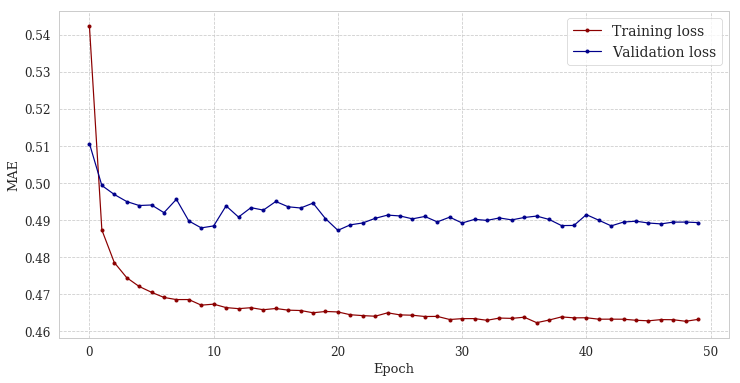

Training model mlp_128 #2
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 0s 5us/step - loss: 0.5401 - val_loss: 0.5119

Epoch 00001: val_loss improved from inf to 0.51188, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_2.h5
Epoch 2/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4854 - val_loss: 0.4959

Epoch 00002: val_loss improved from 0.51188 to 0.49589, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_2.h5
Epoch 3/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4769 - val_loss: 0.4919

Epoch 00003: val_loss improved from 0.49589 to 0.49187, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_2.h5
Epoch 4/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4734 - val_loss: 0.4964

Epoch 00004: val_loss did not improve from 0.49187
Epoch 5/50
53210/53210 [==========

53210/53210 [==============================] - 0s 3us/step - loss: 0.4622 - val_loss: 0.4878

Epoch 00048: val_loss did not improve from 0.48386
Epoch 49/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4627 - val_loss: 0.4881

Epoch 00049: val_loss did not improve from 0.48386
Epoch 50/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4626 - val_loss: 0.4878

Epoch 00050: val_loss did not improve from 0.48386


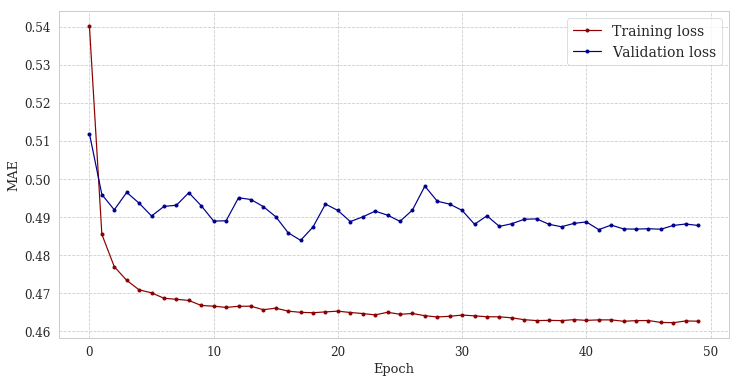

Training model mlp_128 #3
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.5380 - val_loss: 0.5084

Epoch 00001: val_loss improved from inf to 0.50838, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_3.h5
Epoch 2/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4861 - val_loss: 0.5033

Epoch 00002: val_loss improved from 0.50838 to 0.50331, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_3.h5
Epoch 3/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4774 - val_loss: 0.4987

Epoch 00003: val_loss improved from 0.50331 to 0.49873, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_3.h5
Epoch 4/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4739 - val_loss: 0.4947

Epoch 00004: val_loss improved from 0.49873 to 0.49472, saving model to /home/shomeb/

53210/53210 [==============================] - 0s 3us/step - loss: 0.4634 - val_loss: 0.4863

Epoch 00045: val_loss did not improve from 0.48143
Epoch 46/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4623 - val_loss: 0.4865

Epoch 00046: val_loss did not improve from 0.48143
Epoch 47/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4624 - val_loss: 0.4866

Epoch 00047: val_loss did not improve from 0.48143
Epoch 48/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4627 - val_loss: 0.4864

Epoch 00048: val_loss did not improve from 0.48143
Epoch 49/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4623 - val_loss: 0.4868

Epoch 00049: val_loss did not improve from 0.48143

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 50/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4623 - val_loss: 0.4867

Epoch 00050: val_loss did not improve from 0.48143


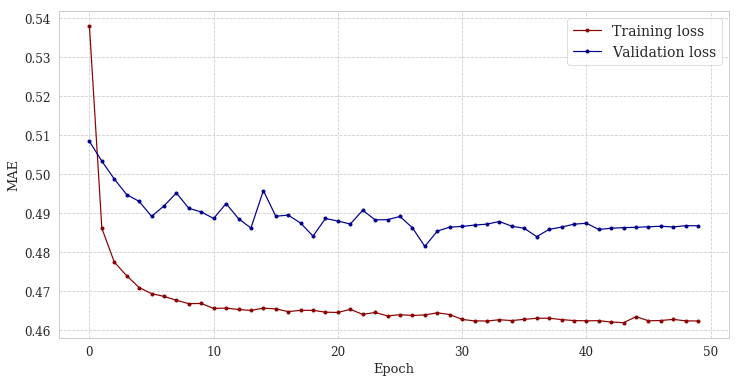

Training model mlp_128 #4
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.5441 - val_loss: 0.5129

Epoch 00001: val_loss improved from inf to 0.51294, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_4.h5
Epoch 2/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4885 - val_loss: 0.4992

Epoch 00002: val_loss improved from 0.51294 to 0.49919, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_4.h5
Epoch 3/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4794 - val_loss: 0.4928

Epoch 00003: val_loss improved from 0.49919 to 0.49278, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_4.h5
Epoch 4/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4742 - val_loss: 0.4934

Epoch 00004: val_loss did not improve from 0.49278
Epoch 5/50
53210/53210 [==========

53210/53210 [==============================] - 0s 4us/step - loss: 0.4622 - val_loss: 0.4874

Epoch 00048: val_loss did not improve from 0.48501
Epoch 49/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4626 - val_loss: 0.4872

Epoch 00049: val_loss did not improve from 0.48501
Epoch 50/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4623 - val_loss: 0.4876

Epoch 00050: val_loss did not improve from 0.48501


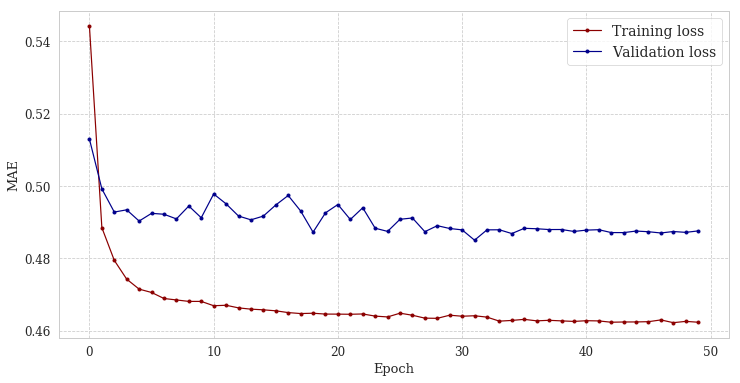

Training model mlp_128 #5
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.5367 - val_loss: 0.5067

Epoch 00001: val_loss improved from inf to 0.50671, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_5.h5
Epoch 2/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4872 - val_loss: 0.4993

Epoch 00002: val_loss improved from 0.50671 to 0.49927, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_5.h5
Epoch 3/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4781 - val_loss: 0.4940

Epoch 00003: val_loss improved from 0.49927 to 0.49399, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_128/50/weights_5.h5
Epoch 4/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4741 - val_loss: 0.4934

Epoch 00004: val_loss improved from 0.49399 to 0.49343, saving model to /home/shomeb/


Epoch 00046: val_loss did not improve from 0.48245
Epoch 47/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4622 - val_loss: 0.4861

Epoch 00047: val_loss did not improve from 0.48245
Epoch 48/50
53210/53210 [==============================] - 0s 4us/step - loss: 0.4627 - val_loss: 0.4867

Epoch 00048: val_loss did not improve from 0.48245

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 49/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4618 - val_loss: 0.4865

Epoch 00049: val_loss did not improve from 0.48245
Epoch 50/50
53210/53210 [==============================] - 0s 3us/step - loss: 0.4622 - val_loss: 0.4865

Epoch 00050: val_loss did not improve from 0.48245


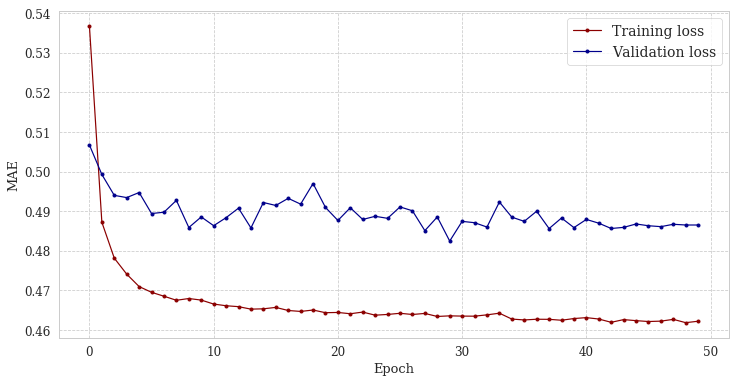


**** Validation ****
Averaged over 5 iterations
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.65335 |             2206.14753 |
|  1 | TT    |              0.29338 |                0.28649 |
|  2 | PT    |              0.50525 |                0.12504 |
|  3 | Avg   |              0.48399 |              735.51969 |
+----+-------+----------------------+------------------------+

**** Testing ****
Averaged over 5 iterations
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.59124 |             1996.43185 |
|  1 | TT    |              0.23489 |                0.22938 |
|  2 | PT    |              0.49354 |                0.12214 |
|  3 | Avg   |         

In [12]:
K.clear_session()

batch_size=256
epochs=50
name = "mlp_128"

mlp_128_dict = evaluate_mlp(mlp_128, 
                            train_tuple=(x_train, y_train), 
                            valid_tuple=(x_valid, y_valid), 
                            test_tuple=(x_test, y_test), 
                            name=name, 
                            epochs=epochs,
                            iterations=5,
                            batch_size=batch_size)

## MLP with 512 hidden nodes

In [13]:
def mlp_512(num_inputs, num_outputs):
    
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_inputs,), kernel_initializer = 'glorot_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(num_outputs))
              
    return model

Training model mlp_512 #1
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.5012 - val_loss: 0.5053

Epoch 00001: val_loss improved from inf to 0.50526, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_1.h5
Epoch 2/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.4666 - val_loss: 0.4939

Epoch 00002: val_loss improved from 0.50526 to 0.49393, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_1.h5
Epoch 3/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.4612 - val_loss: 0.4891

Epoch 00003: val_loss improved from 0.49393 to 0.48912, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_1.h5
Epoch 4/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.4588 - val_loss: 0.4951

Epoch 00004: val_loss did not improve from 0.48912
Epoch 5/50
53210/53210 [==========

53210/53210 [==============================] - 0s 7us/step - loss: 0.4467 - val_loss: 0.4840

Epoch 00049: val_loss did not improve from 0.47908
Epoch 50/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4466 - val_loss: 0.4840

Epoch 00050: val_loss did not improve from 0.47908


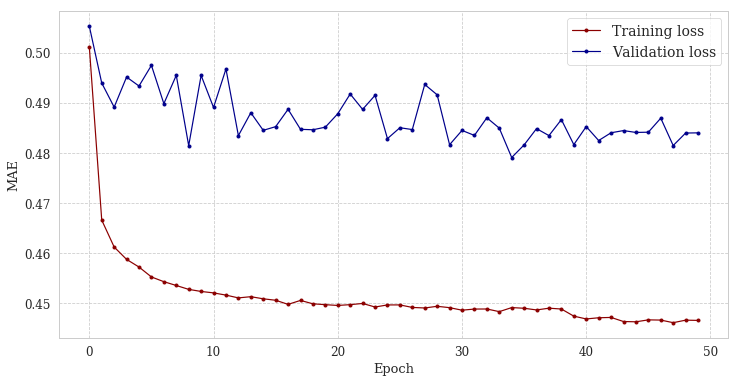

Training model mlp_512 #2
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.5032 - val_loss: 0.5014

Epoch 00001: val_loss improved from inf to 0.50144, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_2.h5
Epoch 2/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4667 - val_loss: 0.4935

Epoch 00002: val_loss improved from 0.50144 to 0.49348, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_2.h5
Epoch 3/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.4609 - val_loss: 0.4920

Epoch 00003: val_loss improved from 0.49348 to 0.49202, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_2.h5
Epoch 4/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.4586 - val_loss: 0.4958

Epoch 00004: val_loss did not improve from 0.49202
Epoch 5/50
53210/53210 [==========


Epoch 00046: val_loss did not improve from 0.48054
Epoch 47/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.4463 - val_loss: 0.4834

Epoch 00047: val_loss did not improve from 0.48054

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 48/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.4464 - val_loss: 0.4833

Epoch 00048: val_loss did not improve from 0.48054
Epoch 49/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.4461 - val_loss: 0.4833

Epoch 00049: val_loss did not improve from 0.48054
Epoch 50/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.4460 - val_loss: 0.4834

Epoch 00050: val_loss did not improve from 0.48054


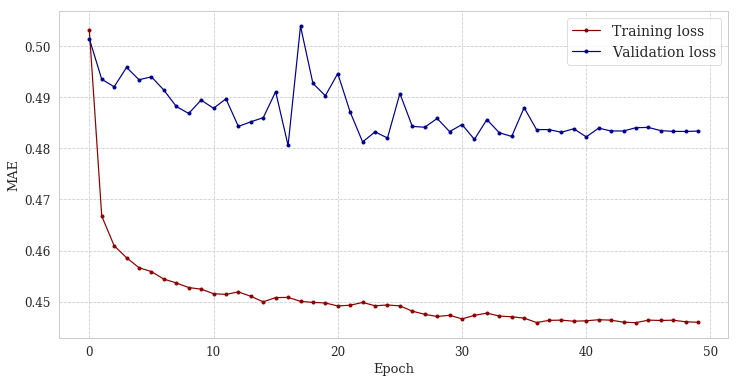

Training model mlp_512 #3
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4948 - val_loss: 0.5024

Epoch 00001: val_loss improved from inf to 0.50239, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_3.h5
Epoch 2/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.4650 - val_loss: 0.5017

Epoch 00002: val_loss improved from 0.50239 to 0.50171, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_3.h5
Epoch 3/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.4606 - val_loss: 0.4928

Epoch 00003: val_loss improved from 0.50171 to 0.49276, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_3.h5
Epoch 4/50
53210/53210 [==============================] - 0s 6us/step - loss: 0.4583 - val_loss: 0.4942

Epoch 00004: val_loss did not improve from 0.49276
Epoch 5/50
53210/53210 [==========

53210/53210 [==============================] - 0s 9us/step - loss: 0.4457 - val_loss: 0.4843

Epoch 00046: val_loss did not improve from 0.48015
Epoch 47/50
53210/53210 [==============================] - 1s 10us/step - loss: 0.4465 - val_loss: 0.4844

Epoch 00047: val_loss did not improve from 0.48015
Epoch 48/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4466 - val_loss: 0.4842

Epoch 00048: val_loss did not improve from 0.48015
Epoch 49/50
53210/53210 [==============================] - 0s 9us/step - loss: 0.4463 - val_loss: 0.4844

Epoch 00049: val_loss did not improve from 0.48015
Epoch 50/50
53210/53210 [==============================] - 1s 10us/step - loss: 0.4464 - val_loss: 0.4846

Epoch 00050: val_loss did not improve from 0.48015


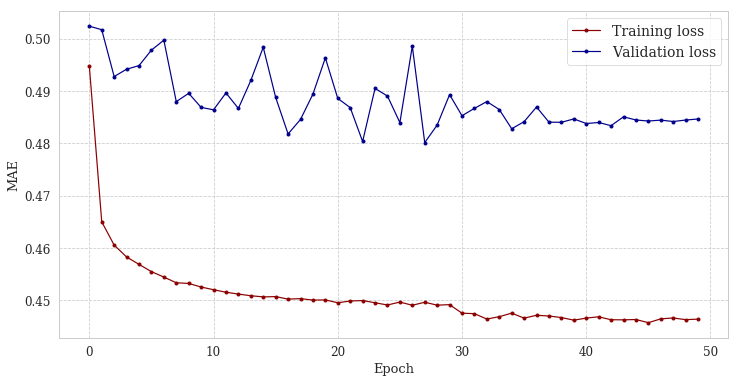

Training model mlp_512 #4
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 1s 11us/step - loss: 0.4983 - val_loss: 0.4968

Epoch 00001: val_loss improved from inf to 0.49680, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_4.h5
Epoch 2/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4657 - val_loss: 0.4967

Epoch 00002: val_loss improved from 0.49680 to 0.49671, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_4.h5
Epoch 3/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4614 - val_loss: 0.5046

Epoch 00003: val_loss did not improve from 0.49671
Epoch 4/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4586 - val_loss: 0.5015

Epoch 00004: val_loss did not improve from 0.49671
Epoch 5/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4567 - val_loss: 0.4948

Epoch 00005: val_l

53210/53210 [==============================] - 0s 7us/step - loss: 0.4468 - val_loss: 0.4823

Epoch 00045: val_loss did not improve from 0.47918
Epoch 46/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4466 - val_loss: 0.4834

Epoch 00046: val_loss did not improve from 0.47918
Epoch 47/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4463 - val_loss: 0.4830

Epoch 00047: val_loss did not improve from 0.47918
Epoch 48/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4467 - val_loss: 0.4837

Epoch 00048: val_loss did not improve from 0.47918

Epoch 00048: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 49/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4461 - val_loss: 0.4827

Epoch 00049: val_loss did not improve from 0.47918
Epoch 50/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4463 - val_loss: 0.4836

Epoch 00050: val_loss did not improve fro

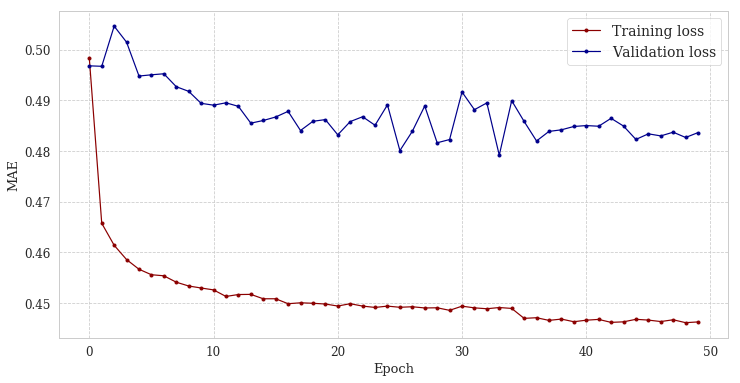

Training model mlp_512 #5
Train on 53210 samples, validate on 17736 samples
Epoch 1/50
53210/53210 [==============================] - 1s 12us/step - loss: 0.4989 - val_loss: 0.5120

Epoch 00001: val_loss improved from inf to 0.51196, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_5.h5
Epoch 2/50
53210/53210 [==============================] - 0s 8us/step - loss: 0.4668 - val_loss: 0.4952

Epoch 00002: val_loss improved from 0.51196 to 0.49521, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_5.h5
Epoch 3/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4617 - val_loss: 0.4920

Epoch 00003: val_loss improved from 0.49521 to 0.49204, saving model to /home/shomeb/h/halvorre/master-thesis/models/mlp_512/50/weights_5.h5
Epoch 4/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4586 - val_loss: 0.4995

Epoch 00004: val_loss did not improve from 0.49204
Epoch 5/50
53210/53210 [=========

53210/53210 [==============================] - 0s 7us/step - loss: 0.4463 - val_loss: 0.4836

Epoch 00047: val_loss did not improve from 0.47999
Epoch 48/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4468 - val_loss: 0.4842

Epoch 00048: val_loss did not improve from 0.47999
Epoch 49/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4463 - val_loss: 0.4844

Epoch 00049: val_loss did not improve from 0.47999
Epoch 50/50
53210/53210 [==============================] - 0s 7us/step - loss: 0.4465 - val_loss: 0.4870

Epoch 00050: val_loss did not improve from 0.47999

Epoch 00050: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


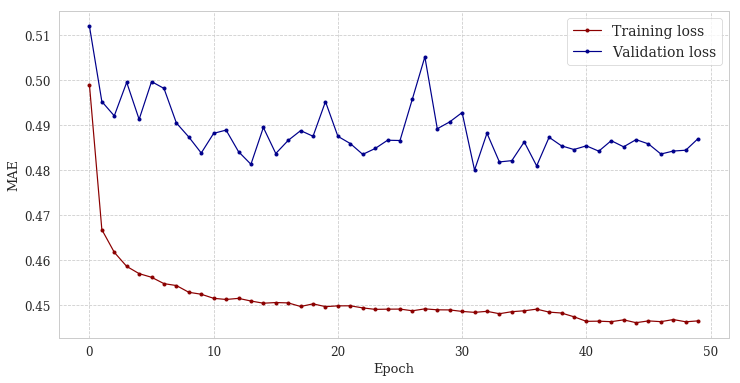


**** Validation ****
Averaged over 5 iterations
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.64624 |             2182.15014 |
|  1 | TT    |              0.29254 |                0.28568 |
|  2 | PT    |              0.50058 |                0.12389 |
|  3 | Avg   |              0.47979 |              727.51990 |
+----+-------+----------------------+------------------------+

**** Testing ****
Averaged over 5 iterations
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.58227 |             1966.14989 |
|  1 | TT    |              0.23396 |                0.22847 |
|  2 | PT    |              0.48717 |                0.12057 |
|  3 | Avg   |         

In [14]:
K.clear_session()

batch_size=256
epochs=50
name = "mlp_512"

mlp_512_dict = evaluate_mlp(mlp_512, 
                            train_tuple=(x_train, y_train), 
                            valid_tuple=(x_valid, y_valid), 
                            test_tuple=(x_test, y_test), 
                            name=name, 
                            epochs=epochs,
                            iterations=5,
                            batch_size=batch_size)

In [ ]:
mlp_512_dict['val_results']['err_df']